<a href="https://colab.research.google.com/github/D-Mahajan/Detecting-Parkinson-Disease/blob/main/ShapeAI_Parkinson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from tqdm import tqdm
sns.set()
from sklearn.model_selection import train_test_split
from sklearn import metrics, preprocessing
from sklearn.metrics import confusion_matrix,accuracy_score
# Library for the statistic data vizualisation
import seaborn

In [ ]:
!pip install xgboost

# Colab-Drive Linking

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
address_folder = "/content/drive/MyDrive/Parkinson/" 

# Load Dataset

In [ ]:
df=pd.read_csv(address_folder + 'parkinsons.data')
df.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,0.02182,0.03130,0.02971,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,0.03134,0.04518,0.04368,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,0.02757,0.03858,0.03590,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,0.02924,0.04005,0.03772,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,0.03490,0.04825,0.04465,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335



**Parkinsons Disease Data Set**

**Dataset information:**

This dataset is composed of a range of biomedical voice measurements from 31 people, 23 with Parkinson's disease (PD). Each column in the table is a particular voice measure, and each row corresponds one of 195 voice recording from these individuals ("name" column). The main aim of the data is to discriminate healthy people from those with PD, according to "status" column which is set to 0 for healthy and 1 for PD.

The data is in ASCII CSV format. The rows of the CSV file contain an instance corresponding to one voice recording. There are around six recordings per patient, the name of the patient is identified in the first column.


---


**Attribute Information:**

Matrix column entries (attributes):

    name - ASCII subject name and recording number
    MDVP:Fo(Hz) - Average vocal fundamental frequency
    MDVP:Fhi(Hz) - Maximum vocal fundamental frequency
    MDVP:Flo(Hz) - Minimum vocal fundamental frequency * MDVP:Jitter(%),   MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP - Several measures of variation in fundamental frequency
    MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA - Several measures of variation in amplitude
    NHR,HNR - Two measures of ratio of noise to tonal components in the voice
    status - Health status of the subject (one) - Parkinson's, (zero) - healthy
    RPDE,D2 - Two nonlinear dynamical complexity measures
    DFA - Signal fractal scaling exponent * spread1,spread2,PPE - Three nonlinear measures of fundamental frequency variation


In [ ]:
df.isnull().sum()

name                0
MDVP:Fo(Hz)         0
MDVP:Fhi(Hz)        0
MDVP:Flo(Hz)        0
MDVP:Jitter(%)      0
MDVP:Jitter(Abs)    0
MDVP:RAP            0
MDVP:PPQ            0
Jitter:DDP          0
MDVP:Shimmer        0
MDVP:Shimmer(dB)    0
Shimmer:APQ3        0
Shimmer:APQ5        0
MDVP:APQ            0
Shimmer:DDA         0
NHR                 0
HNR                 0
status              0
RPDE                0
DFA                 0
spread1             0
spread2             0
D2                  0
PPE                 0
dtype: int64

1    147
0     48
Name: status, dtype: int64


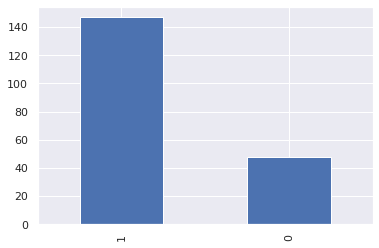

In [ ]:


## checking the balance of the data by plotting the count of outcomes by their value
color_wheel = {1: "#0392cf", 
               2: "#7bc043"}
colors = df["status"].map(lambda x: color_wheel.get(x + 1))
print(df.status.value_counts())
p=df.status.value_counts().plot(kind="bar")



As we can see, the dataset contains more number of patients (almost 3 times) suffering from Parkinson's disease (status = 1) as compared to patients who are not.

In [ ]:
df = df.drop('name',axis=1)

df.describe().T

,count,mean,std,min,25%,50%,75%,max
MDVP:Fo(Hz),195.0,154.228641,41.390065,88.333000,117.572000,148.790000,182.769000,260.105000
MDVP:Fhi(Hz),195.0,197.104918,91.491548,102.145000,134.862500,175.829000,224.205500,592.030000
MDVP:Flo(Hz),195.0,116.324631,43.521413,65.476000,84.291000,104.315000,140.018500,239.170000
MDVP:Jitter(%),195.0,0.006220,0.004848,0.001680,0.003460,0.004940,0.007365,0.033160
MDVP:Jitter(Abs),195.0,0.000044,0.000035,0.000007,0.000020,0.000030,0.000060,0.000260
MDVP:RAP,195.0,0.003306,0.002968,0.000680,0.001660,0.002500,0.003835,0.021440
MDVP:PPQ,195.0,0.003446,0.002759,0.000920,0.001860,0.002690,0.003955,0.019580
Jitter:DDP,195.0,0.009920,0.008903,0.002040,0.004985,0.007490,0.011505,0.064330
MDVP:Shimmer,195.0,0.029709,0.018857,0.009540,0.016505,0.022970,0.037885,0.119080
MDVP:Shimmer(dB),195.0,0.282251,0.194877,0.085000,0.148500,0.221000,0.350000,1.302000


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `hist

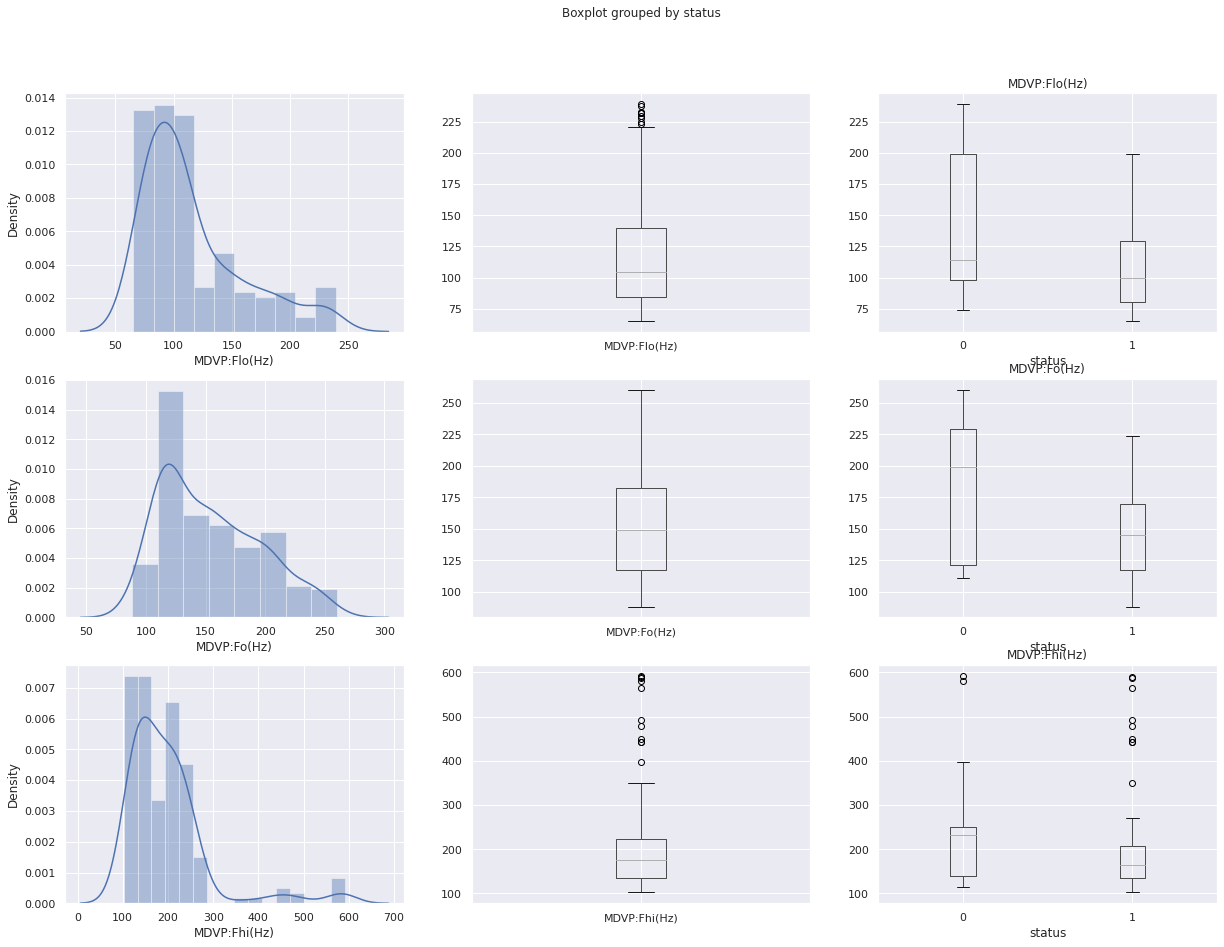

In [ ]:
fig, ax = plt.subplots(3,3,figsize=(20,15)) 

MDVP_F_list = ["MDVP:Flo(Hz)" , "MDVP:Fo(Hz)" , "MDVP:Fhi(Hz)"]

for i in range(0,3):
    sns.distplot(df[MDVP_F_list[i]] , hist = True, kde = True , ax = ax[i,0])
    df.boxplot(MDVP_F_list[i] , ax = ax[i,1])
    df.boxplot(MDVP_F_list[i], "status", ax = ax[i,2])



In the figure above, univariate analysis and bivariate analysis is done for the average, minimum and maximum vocal fundamental frequency. The first column and the second column shows the histogram and boxplots respectively. The last column shows the box plots between the vocal fundamental frequencies and status, which is our target variable.

The histograms for the maximum and minimum vocal fundamental frequencies show positive skewness, having outliers towards the higher range of frequency values. For the average vocal frequency, there is less positive skewness and absense of outliers. 

We can observe that for patients who have Parkinson's disease ( status = 1), the median value for the frequencies is always lower than that for patients without Parkinson's disease. 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `hist

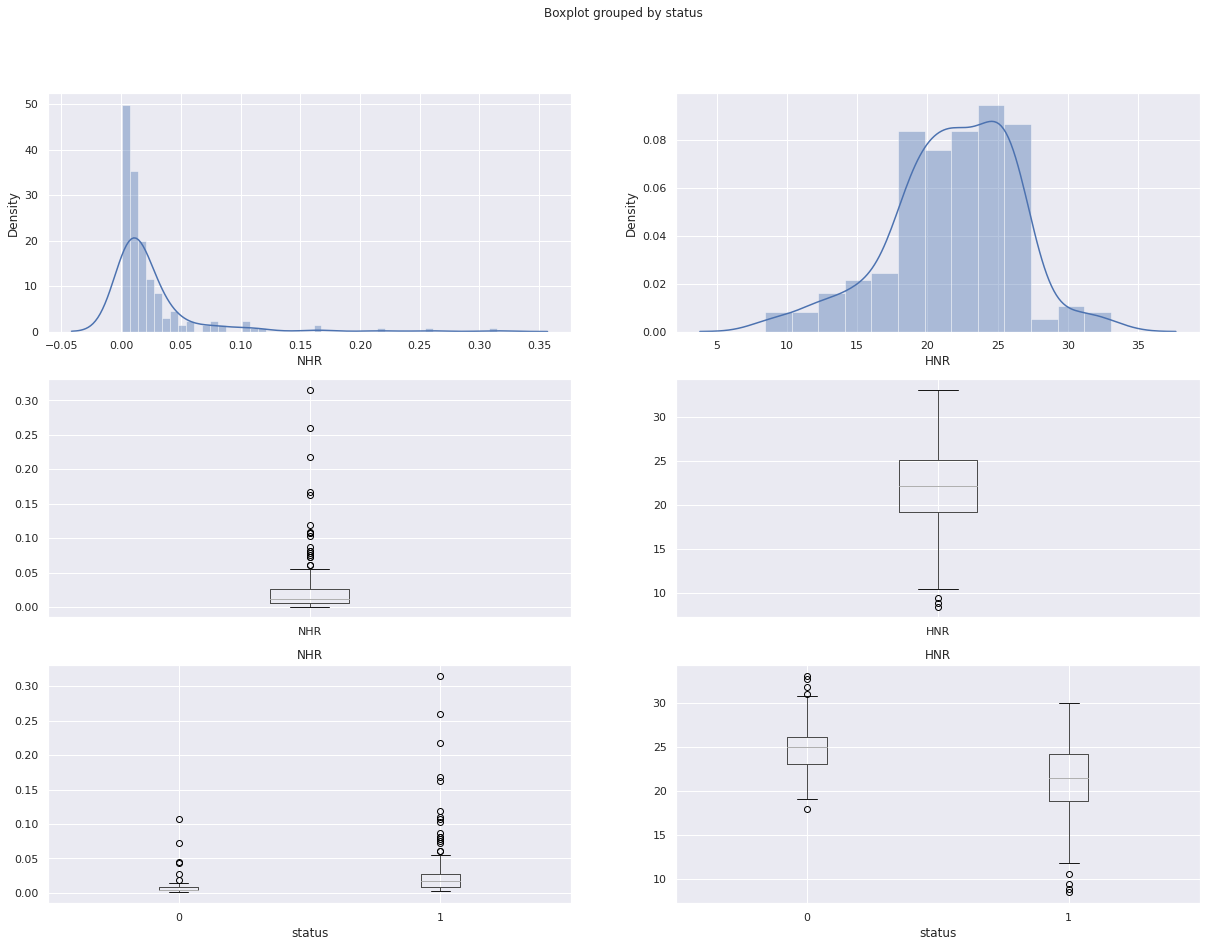

In [ ]:
fig, ax = plt.subplots(3,2,figsize=(20,15)) 

NT_list = ["NHR", "HNR"]

for i in range(0,2):
    sns.distplot(df[NT_list[i]] , hist = True, kde= True, ax = ax[0,i])
    df.boxplot(NT_list[i] , ax = ax[1,i])
    df.boxplot(NT_list[i], "status", ax = ax[2,i])




In the figure above, analysis is done for the two measures of ratio of noise to tonal components in the voice.

For NHR, we can observe a highly positively skewed histogram, along with a number of outliers from 0.05 to about 0.33. The median value of NHR for PD patients is more than that for non-PD.

HNR, has almost no skewness and from the boxplot we can notice that there are outliers present towards the lower values of the ratio. Unlike NHR, the median of HNR for PD patients is less than that for non-PD.


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `hist

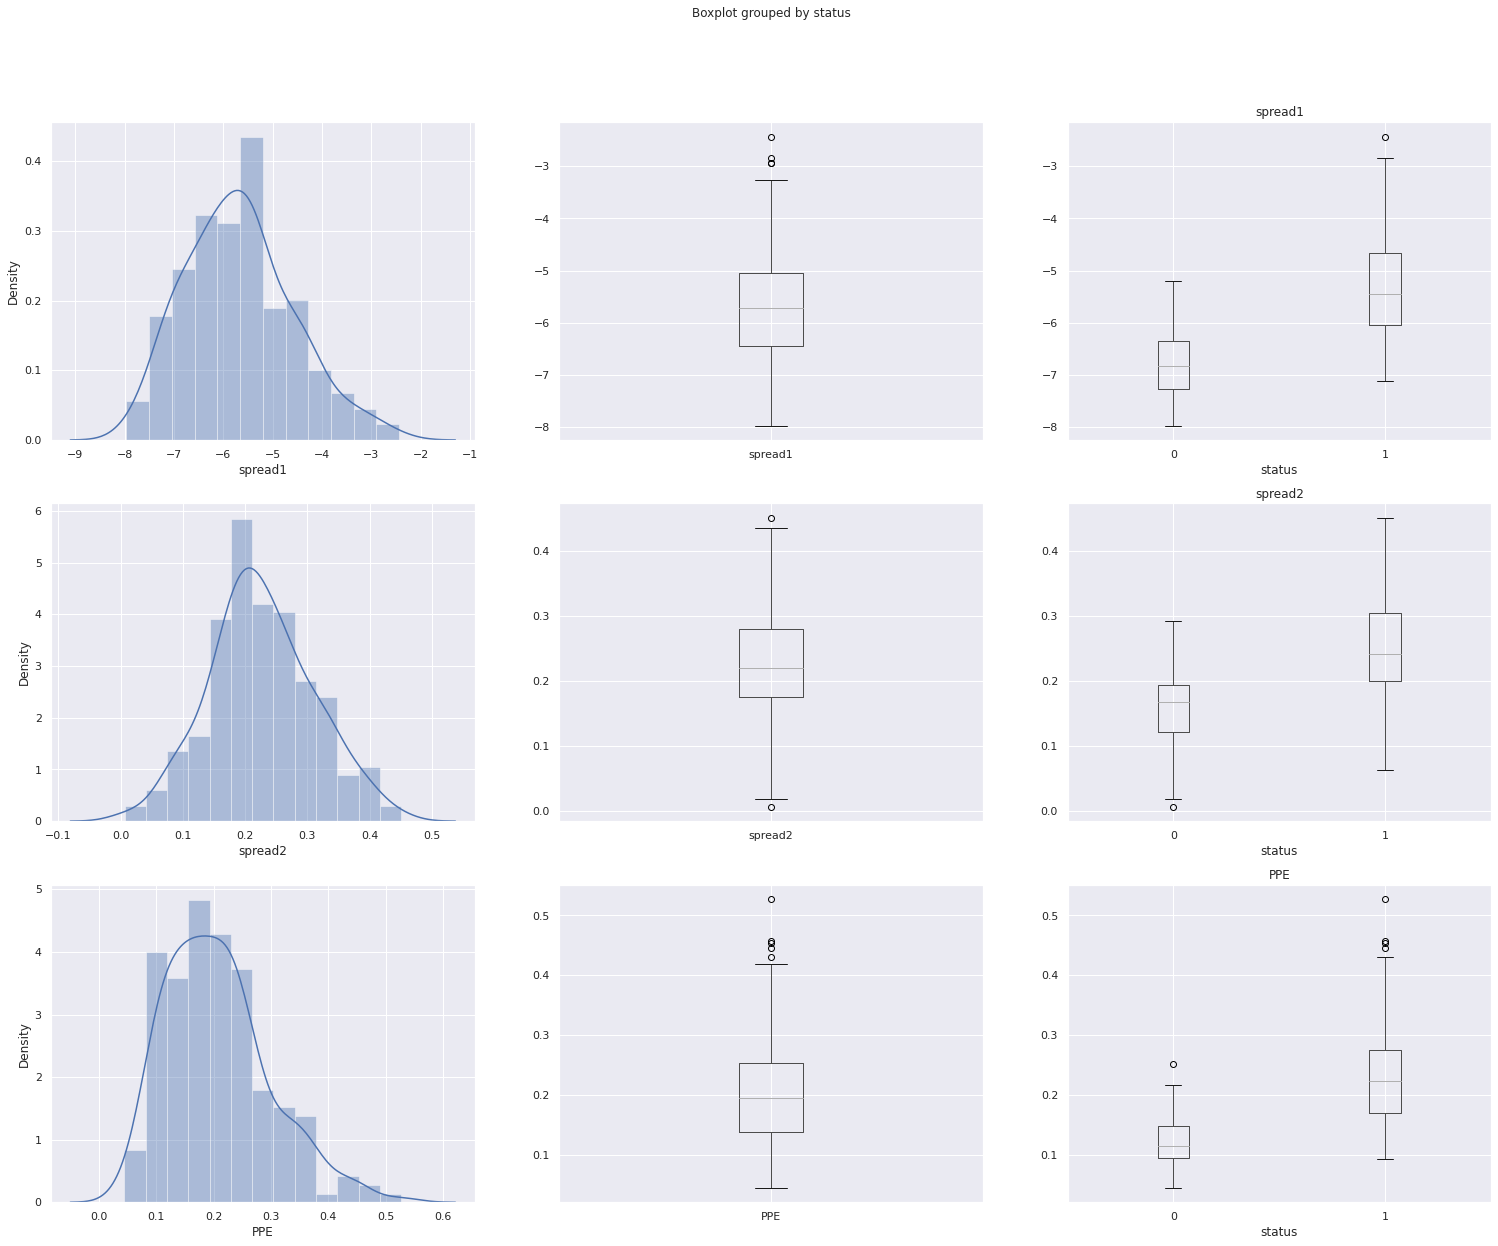

In [ ]:
fig, ax = plt.subplots(3,3,figsize=(25,20)) 

FFV_list = ["spread1" , "spread2" , "PPE"]

for i in range(0,3):
    sns.distplot(df[FFV_list[i]], hist = True, kde =True , ax = ax[i,0])
    df.boxplot(FFV_list[i] , ax = ax[i,1])
    df.boxplot(FFV_list[i], "status", ax = ax[i,2])

In the figure above, univariate analysis and bivariate analysis is done for the spread 1, spread 2 and PPE. 

From the plots for the variables, we can observe that the skewness for all the variables is almost zero and outliers are present for all of them but in lesser number. 

The median value for all the three variables is more for the PD patients.

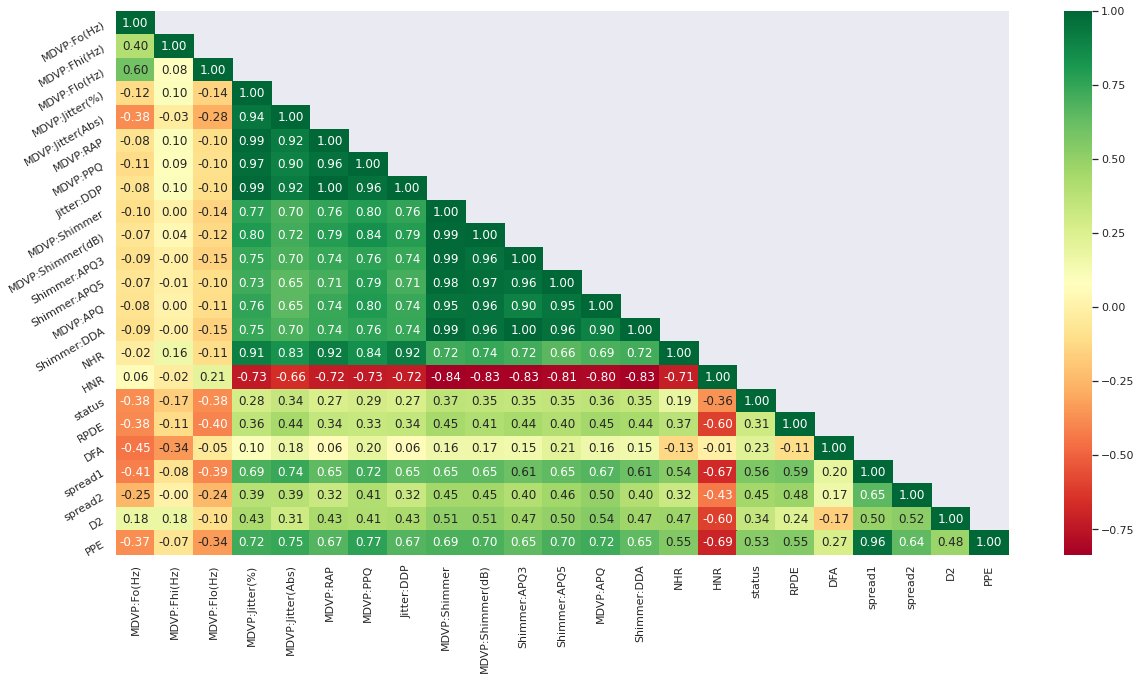

In [ ]:

df_corr = df.corr()

sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 3.5})
plt.figure(figsize=(20,10))  # on this line I just set the size of figure to 20 by 10.
mask = np.zeros_like(df_corr)
mask[np.triu_indices_from(mask, 1)] = True
p=sns.heatmap(df_corr,mask = mask, annot=True,cmap ='RdYlGn' , fmt = '.2f')

rotx = p.set_xticklabels(p.get_xticklabels(), rotation=90)
roty = p.set_yticklabels(p.get_yticklabels(), rotation=30)

The heat map provides insight into the correlation between the different variables/ features related to parkinson's disease. A darker shade of green represents high positive correlation, while a darker shade of red/maroon depicts high negative correlation.

MDVP:Jitter(%) has a very high correlation with MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ and Jitter:DDP.MDVP:Shimmer has a very high correlation with MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA

The target variable, status, has a weak positive correlation ( highest with respect to other variables ) with spread 1, followed by PPE and spread 2.

# Get Labels and Features

In [ ]:
def get_features_labels(data):
  return data.loc[:,'status'].values, data.loc[:,df.columns!='status'].values[:,1:]

labels, features = get_features_labels(df)


# Normalize Data

In [ ]:
def get_normalize(f):
  min_max_scaler = preprocessing.MinMaxScaler()
  return min_max_scaler.fit_transform(f)

In [ ]:
y = labels
x = get_normalize(features)

# Different Classifiers
  


### K-Nearest Neighbours

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
def knn_model(X_tr,Y_tr,X_te,Y_te):
  test_scores, train_scores = [],[]

  for i in tqdm(range(1,15,1)):

      knn = KNeighborsClassifier(i)
      knn.fit(X_tr,Y_tr)
      
      train_scores.append(knn.score(X_tr,Y_tr))
      test_scores.append(knn.score(X_te,Y_te))
  max_test_score = max(test_scores)
  test_scores_ind = [i for i, v in enumerate(test_scores) if v == max_test_score]
  print('Max test score {} % and k = {}'.format(max_test_score*100,list(map(lambda x: x+1, test_scores_ind))))
  return train_scores, test_scores

def knn_get_visualization(train_scores, test_scores):
  plt.figure(figsize=(12,5))
  p = sns.lineplot(range(1,15),train_scores,marker='*',label='Train Score')
  p = sns.lineplot(range(1,15),test_scores,marker='o',label='Test Score')


  ### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
def logReg_model(X_tr,Y_tr,X_te,Y_te):
  logReg = LogisticRegression(solver='lbfgs', max_iter=10000)
  logReg.fit(X_tr,Y_tr)
  predictions = logReg.predict(X_te)  
  score = logReg.score(x_test, y_test)
  print("The accuracy is:  {}".format(score))


### SVM

In [ ]:
from sklearn import svm
def svm_model(X_tr,Y_tr,X_te,Y_te):
  classifier = svm.SVC(kernel='linear')
  classifier.fit(X_tr,Y_tr)
  prediction_SVM_all = classifier.predict(X_te)
  cm = confusion_matrix(Y_te, prediction_SVM_all)
  print("The accuracy is: "+str((cm[0][0]+cm[1][1]) / (sum(cm[0]) + sum(cm[1]))))

### Decision Trees

In [ ]:
from sklearn.tree import DecisionTreeClassifier
def dt_model(X_tr,Y_tr,X_te,Y_te):
  clf = DecisionTreeClassifier(criterion="entropy", max_depth=3)
  clf = clf.fit(X_tr,Y_tr)
  y_pred = clf.predict(X_te)
  print("The accuracy is: ",metrics.accuracy_score(Y_te, y_pred))

### Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
def rf_model(X_tr,Y_tr,X_te,Y_te):
  clf=RandomForestClassifier(n_estimators=100)
  clf.fit(X_tr,Y_tr)
  print("The accuracy is: ",metrics.accuracy_score(Y_te,clf.predict(X_te)))

# Classifier Code


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.7,random_state = 42, shuffle = True)

100%|██████████| 14/14 [00:00<00:00, 103.00it/s]
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Max test score 94.91525423728814 % and k = [1]


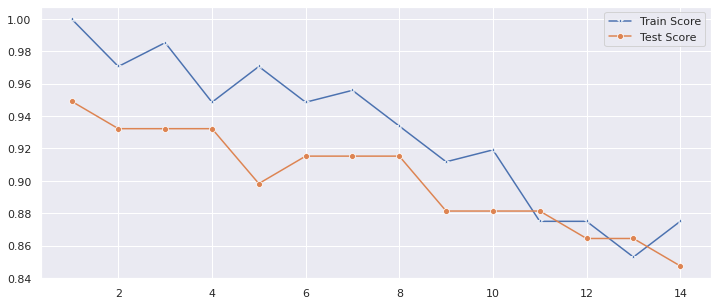

In [ ]:
# K nearest neighbours
train_scores, test_scores = knn_model(x_train,y_train,x_test,y_test)
knn_get_visualization(train_scores, test_scores)

In [ ]:
# Logistic Regression
logReg_model(x_train,y_train,x_test,y_test)

The accuracy is:  0.864406779661017


In [ ]:
# SVM 
svm_model(x_train,y_train,x_test,y_test)

The accuracy is: 0.8813559322033898


In [ ]:
# Decision Trees
dt_model(x_train,y_train,x_test,y_test)

The accuracy is:  0.847457627118644


In [ ]:
# random forest 
rf_model(x_train,y_train,x_test,y_test)

The accuracy is:  0.9491525423728814


In [ ]:
#XGBClassifier

model=XGBClassifier()
model.fit(x_train,y_train)
y_pred=model.predict(x_test)
print(accuracy_score(y_test, y_pred))


0.9322033898305084
